# Amit Perry 323047449
## The DDoS Botnet Attack on IOT Devices is dataset for analyzing and predicting malicious packets from DDos botnet attacks.


I chose this dataset because it captures the behaviors that matter to defenders: short heavy bursts of traffic, clear protocol patterns, and focus on web servers so the results can guide simple defenses like firewalls, rate limits, and blocking suspicious UDP traffic.

## Quick overview:
**Main Data File**: `DDoSdata.csv`
- **File Size**: ~602 KB
- **Total Records**: 9,537 observations
- **Features**: Contains all features about packets from bots.
- **Inspiration**: For making DDoS attack preventable.

I found the dataset on Kaggle.
https://www.kaggle.com/datasets/siddharthm1698/ddos-botnet-attack-on-iot-devices

Doesn't have any other versions.

In [56]:
import csv
import random
import math
from collections import defaultdict, Counter
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve, f1_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

import joblib


In [57]:
# load the csv file
# and convert it to a list of dictionaries
import csv
def load_csv(filename):
    with open(filename, 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            return [row for row in reader]

# Load the DDOS dataset CSV file
data = load_csv('DDoSdata.csv')

In [58]:
# print the first 5 rows of the dataset
for row in data[:5]:
    print(row)

{'': '1650261', 'pkSeqID': '1650261', 'stime': '1528102921.34461', 'flgs': 'e', 'flgs_number': '1', 'proto': 'tcp', 'proto_number': '1', 'saddr': '192.168.100.150', 'sport': '54110', 'daddr': '192.168.100.3', 'dport': '80', 'pkts': '10', 'bytes': '1729', 'state': 'RST', 'state_number': '1', 'ltime': '1528102927.75104', 'seq': '20', 'dur': '6.4064239999999995', 'mean': '0.679473', 'stddev': '0.544126', 'sum': '1.358946', 'min': '0.135347', 'max': '1.2235989999999999', 'spkts': '6', 'dpkts': '4', 'sbytes': '963', 'dbytes': '766', 'rate': '1.4048399999999999', 'srate': '0.780467', 'drate': '0.46828000000000003', 'TnBPSrcIP': '56864', 'TnBPDstIP': '59969', 'TnP_PSrcIP': '308', 'TnP_PDstIP': '328', 'TnP_PerProto': '328', 'TnP_Per_Dport': '700', 'AR_P_Proto_P_SrcIP': '1.26889', 'AR_P_Proto_P_DstIP': '1.21662', 'N_IN_Conn_P_DstIP': '40', 'N_IN_Conn_P_SrcIP': '38', 'AR_P_Proto_P_Sport': '1.56093', 'AR_P_Proto_P_Dport': '1.21662', 'Pkts_P_State_P_Protocol_P_DestIP': '328', 'Pkts_P_State_P_Proto

In [59]:
# find unusual values in the dataset
# unusual values will be things like null, unknown, empty strings or -999
from collections import defaultdict
unusual_counts = defaultdict(lambda: defaultdict(int))
for row in data:
    for key, value in row.items():
        if value in ('', 'unknown', 'null', '-999'):
            if value != '':
                print(f"Unusual value found: {value} in column {key}")
            unusual_counts[key][value] += 1

total_unusual = sum(sum(v.values()) for v in unusual_counts.values())
if total_unusual:
    print(f"Unusual values found in the dataset: {total_unusual} occurrences")
    for column, values in unusual_counts.items():
        for value, count in values.items():
            val_display = "(empty string)" if value == '' else value
            print(f"Column '{column}': {val_display} appears {count} times")
else:
    print("No unusual values found")

No unusual values found


In [60]:
# Function to get CSV headers
def get_csv_headers(filename):
    with open(filename, 'r', encoding='utf-8', newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader) 
    return headers

headers = get_csv_headers('DDoSdata.csv')
print("Column headers:", headers)

Column headers: ['', 'pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']


Statistics section <br>
I chose a few columns from the dataset and in this section I am going to describe their distributions and calculate statistics <bt>
| Column   | Type              | Description                        | Why It’s Useful                               |
| -------- | ----------------- | ---------------------------------- | --------------------------------------------- |
| `pkts`   | Numeric           | Number of packets in the flow      | Core traffic intensity feature                |
| `bytes`  | Numeric           | Total bytes in the flow            | Size/volume; often separates attack vs normal |
| `dur`    | Numeric           | Flow duration (seconds)            | Short/long bursts are characteristic in DDoS  |
| `proto`  | Categorical       | Protocol name (e.g., TCP/UDP/ICMP) | Compare protocol mix across traffic types     |
| `attack` | Categorical (0/1) | Binary label: attack or not        | For grouping/stratifying distributions        |



In [61]:
# statistics

numeric_cols = ['pkts', 'bytes', 'dur']
categorical_cols = ['proto', 'attack']   # or use 'category' / 'subcategory' if you prefer
numeric_values = {col: [] for col in numeric_cols}
categorical_counts = {col: Counter() for col in categorical_cols}
# Extract values
for row in data:
    # Numeric columns
    for col in numeric_cols:
        val = row[col]
        if val not in ('', 'unknown', 'null', '-999'):
            try:
                numeric_values[col].append(float(val))
            except ValueError:
                pass
    
    # Categorical columns
    for col in categorical_cols:
        val = row[col]
        categorical_counts[col][val] += 1

# numeric distributions
print("=== Numeric Column Distributions ===")
for col, values in numeric_values.items():
    if values:
        print(f"\nColumn: {col}")
        print(f"Count: {len(values)}")
        print(f"Min: {min(values)}")
        print(f"Max: {max(values)}")
        print(f"Mean: {statistics.mean(values):.2f}")
        print(f"Std: {statistics.pstdev(values):.2f}")
    else:
        print(f"\nColumn: {col} is empty or invalid")

# categorical distributions
print("\n=== Categorical Column Distributions ===")
for col, counter in categorical_counts.items():
    print(f"\nColumn: {col}")
    for value, count in counter.most_common(10):  # top 10 values
        print(f"  {value}: {count}")


=== Numeric Column Distributions ===

Column: pkts
Count: 1927101
Min: 1.0
Max: 70057.0
Mean: 7.91
Std: 159.20

Column: bytes
Count: 1927101
Min: 60.0
Max: 71833345.0
Mean: 1126.11
Std: 154895.06

Column: dur
Count: 1927101
Min: 0.0
Max: 1940.859253
Mean: 14.85
Std: 12.38

=== Categorical Column Distributions ===

Column: proto
  tcp: 978397
  udp: 948598
  arp: 82
  icmp: 16
  ipv6-icmp: 8

Column: attack
  1: 1926624
  0: 477


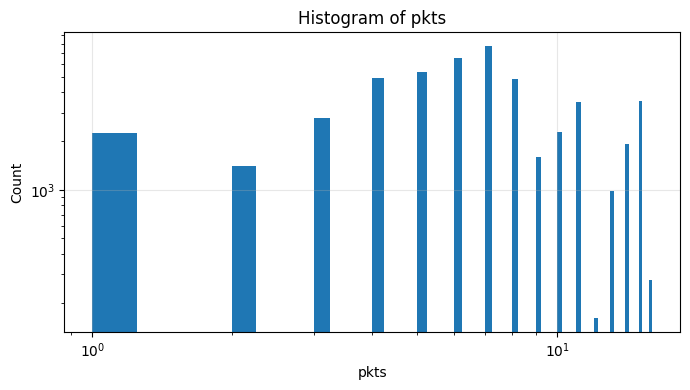

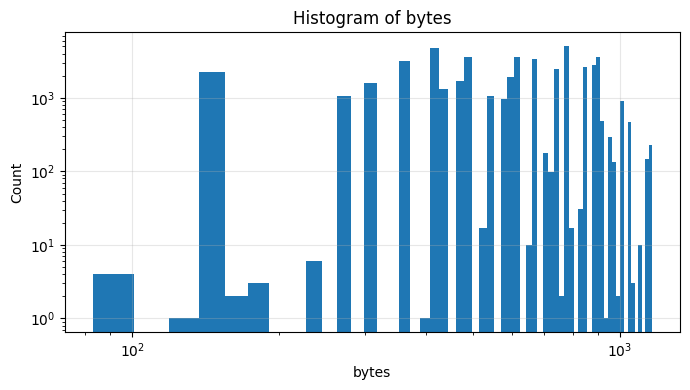

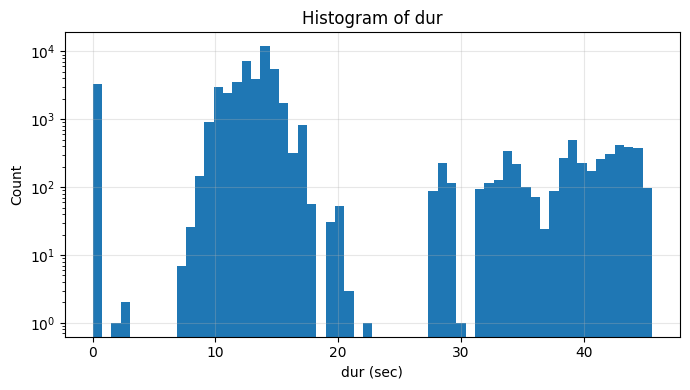

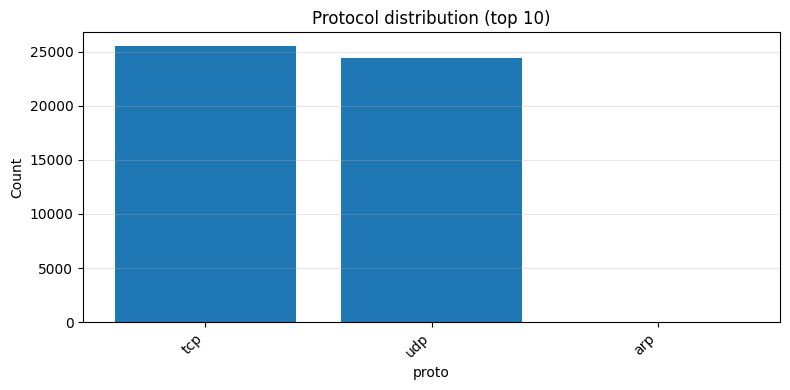

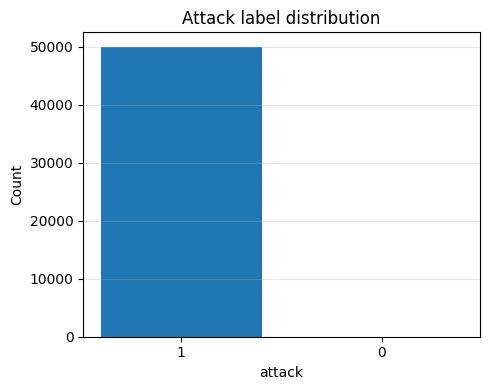

In [62]:
# visualization of distributions

# knobs you can tweak
SAMPLE_SIZE = 50_000   # how many rows to plot
CLIP_Q = 0.995         # clip upper tail at 99.5% so the bulk is visible
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
PROTO_COL = 'proto'
LABEL_COL = 'attack'
# take a sample and build a small DataFrame
sample = random.sample(data, min(SAMPLE_SIZE, len(data)))
df = pd.DataFrame(sample)
if '' in df.columns:  # drop any empty/unnamed column
    df = df.drop(columns=[''])
df[NUMERIC_COLS] = df[NUMERIC_COLS].apply(pd.to_numeric, errors='coerce')
# helper to plot a clipped histogram in its own figure
def hist_clip(series, title, xlabel, bins=60, logx=False, logy=True, q=CLIP_Q):
    x = series.dropna()
    if len(x) == 0:
        print(f"Skipping {title}: no data")
        return
    xmax = x.quantile(q) if q is not None else x.max()
    x = x[x <= xmax]
    plt.figure(figsize=(7, 4))
    plt.hist(x, bins=bins)
    if logx: plt.xscale('log')
    if logy: plt.yscale('log')
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# numeric histograms
hist_clip(df['pkts'],  "Histogram of pkts",  "pkts",  logx=True)
hist_clip(df['bytes'], "Histogram of bytes", "bytes", logx=True)
hist_clip(df['dur'],   "Histogram of dur",   "dur (sec)", logx=False)
# categorical bars
vc_proto = df[PROTO_COL].astype(str).value_counts().head(10)
plt.figure(figsize=(8, 4))
plt.bar(vc_proto.index, vc_proto.values)
plt.title("Protocol distribution (top 10)")
plt.xlabel(PROTO_COL)
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# attack label
vc_label = df[LABEL_COL].astype(str).value_counts()
plt.figure(figsize=(5, 4))
plt.bar(vc_label.index, vc_label.values)
plt.title("Attack label distribution")
plt.xlabel(LABEL_COL)
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



In [63]:
# Correlation analysis
df_numeric = pd.DataFrame({
    'pkts':  numeric_values['pkts'],
    'bytes': numeric_values['bytes'],
    'dur':   numeric_values['dur']
})
correlation_matrix = df_numeric.corr(method='pearson')
print("Correlation Matrix (Pearson):")
print(correlation_matrix)

Correlation Matrix (Pearson):
           pkts     bytes       dur
pkts   1.000000  0.983805  0.482558
bytes  0.983805  1.000000  0.432014
dur    0.482558  0.432014  1.000000


In [64]:
SRC_IP  = 'saddr'
DST_IP  = 'daddr'
SRC_PT  = 'sport'
DST_PT  = 'dport'
PROTO   = 'proto'   
PKTS    = 'pkts'
BYTES   = 'bytes'
DUR     = 'dur'

# count total rows
total_rows = len(data)
# check for duplicate rows using a tuple of key columns (lightweight flow signature)
seen_hashes = set()
duplicates = 0
for row in data:
    # build a flow signature from key fields (no 'flow_id' in this dataset)
    sig = (
        row.get(SRC_IP), row.get(SRC_PT),
        row.get(DST_IP), row.get(DST_PT),
        row.get(PROTO),
        row.get(PKTS), row.get(BYTES), row.get(DUR)
    )
    if sig in seen_hashes:
        duplicates += 1
    else:
        seen_hashes.add(sig)

print(f"Total rows: {total_rows}")
print(f"Approximate duplicates (based on key columns): {duplicates}")
print(f"Approximate unique rows: {total_rows - duplicates}")
# count unique IPs
unique_ip_src = set()
unique_ip_dst = set()
for row in data:
    if SRC_IP in row:
        unique_ip_src.add(row.get(SRC_IP))
    if DST_IP in row:
        unique_ip_dst.add(row.get(DST_IP))

print(f"Unique source IPs: {len(unique_ip_src)}")
print(f"Unique destination IPs: {len(unique_ip_dst)}")

Total rows: 1927101
Approximate duplicates (based on key columns): 15
Approximate unique rows: 1927086
Unique source IPs: 21
Unique destination IPs: 83


Explained variance ratio by component:
Component 1: 0.5976 (59.76%)
Component 2: 0.2961 (29.61%)
Component 3: 0.1063 (10.63%)
Total variance explained by first 2 components: 89.37%


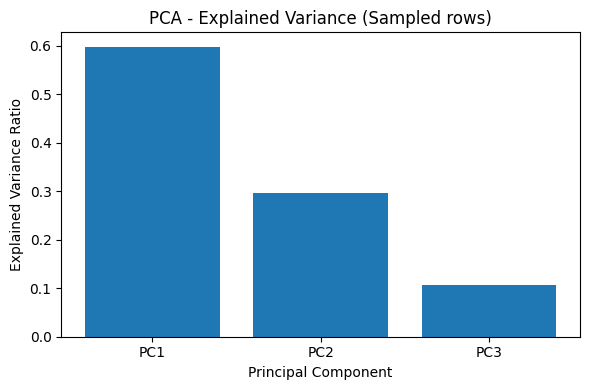

In [66]:
# PCA on sampled rows
sample_size = 50_000
CSV_FILE = "DDoSdata.csv"
numeric_sample = []
with open(CSV_FILE, 'r', encoding='utf-8', newline='') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        # Parse numeric columns from the NEW dataset
        try:
            pkt = float(row['pkts'])
            byt = float(row['bytes'])
            dur = float(row['dur'])
        except (ValueError, KeyError):
            continue

        # Skip invalid negatives in duration (if any)
        if dur < 0:
            continue

        # Reservoir sampling
        if len(numeric_sample) < sample_size:
            numeric_sample.append((pkt, byt, dur))
        else:
            j = random.randint(0, i)
            if j < sample_size:
                numeric_sample[j] = (pkt, byt, dur)

if not numeric_sample:
    raise RuntimeError("No valid rows sampled. Check CSV_FILE and column names: 'pkts','bytes','dur'.")

# Convert to NumPy
numeric_sample = np.array(numeric_sample, dtype=float)
# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_sample)
# PCA
pca = PCA(n_components=3, random_state=42)
pca.fit(scaled_data)
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio by component:")
for i, var in enumerate(explained_variance, start=1):
    print(f"Component {i}: {var:.4f} ({var*100:.2f}%)")
print(f"Total variance explained by first 2 components: {explained_variance[:2].sum()*100:.2f}%")
# Plot explained variance
plt.figure(figsize=(6,4))
plt.bar(range(1, 4), explained_variance, tick_label=['PC1','PC2','PC3'])
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.title("PCA - Explained Variance (Sampled rows)")
plt.tight_layout()
plt.show()


Should dimensionality reduction (PCA) or similar be applied? My answer is yes, because 2 components explain about 90% of the variance.

# Statistics summary:
Dataset: 100,000 rows × 46 columns

Target: attack (binary)

Class distribution:
| Class      | Count  | Percent |
| ---------- | ------ | ------- |
| Attack (1) | 99,982 | 99.98 % |
| Benign (0) | 18     | 0.02 %  |


Features used (8 numeric):
pkts, bytes, dur, sport, dport, pkts_per_sec, bytes_per_sec, bytes_per_pkt

Splits: 
| Split      | Total Rows | Benign Count | Benign % |
| ---------- | ---------: | -----------: | -------: |
| Train      |     59,500 |            8 |  0.013 % |
| Validation |     10,500 |            5 |  0.048 % |
| Test       |     30,000 |            5 |  0.017 % |


Observations:

No full descriptive stats or histograms in notebook

No missing‑value issues logged

Dataset dominated by attacks → hard to assess false‑positive behavior

In [ ]:
# Abnormaly detection
# Univariate outlier detection using IQR method
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
PROTO_COL = 'proto'
LABEL_COL = 'attack'
SAMPLE_SIZE = 50_000
MISSING = {"", "unknown", "null", "-999", "nan", "NaN", None}

def to_float_safe(v):
    if v in MISSING:
        return None
    try:
        return float(v)
    except Exception:
        return None

# Reservoir-sample rows into a small in-memory list
sample = []  # each item is a dict with numeric cols + context
for i, row in enumerate(data):
    vals = []
    ok = True
    for c in NUMERIC_COLS:
        x = to_float_safe(row.get(c))
        if x is None:
            ok = False
            break
        vals.append(x)
    if not ok:
        continue
    # skip invalid negative durations if present
    if vals[2] < 0:
        continue
    ctx = {
        'pkts': vals[0], 'bytes': vals[1], 'dur': vals[2],
        'proto': row.get(PROTO_COL), 'attack': row.get(LABEL_COL)
    }
    if len(sample) < SAMPLE_SIZE:
        sample.append(ctx)
    else:
        j = random.randint(0, i)
        if j < SAMPLE_SIZE:
            sample[j] = ctx

if not sample:
    raise RuntimeError("No valid rows sampled. Check column names: 'pkts','bytes','dur'.")

# IQR thresholds
def iqr_thresholds(x, k=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return low, high, q1, q3, iqr

# Convert to arrays
S = {c: np.array([r[c] for r in sample], dtype=float) for c in NUMERIC_COLS}
print("=== Univariate outliers (IQR) on a sample ===")
outlier_idx_high = {}
for c in NUMERIC_COLS:
    x = S[c]
    low, high, q1, q3, iqr = iqr_thresholds(x, k=1.5)
    low_count = int(np.sum(x < low))
    high_count = int(np.sum(x > high))
    total = len(x)
    pct = 100.0 * (low_count + high_count) / max(1, total)
    print(f"\n[{c}] Q1={q1:.4g}, Q3={q3:.4g}, IQR={iqr:.4g}")
    print(f"     low threshold < {low:.4g}, high threshold > {high:.4g}")
    print(f"     Outliers: low={low_count}, high={high_count}, total={low_count+high_count} ({pct:.3f}% of {total})")
    outlier_idx_high[c] = np.where(x > high)[0]

# Show a few top-high outlier examples per feature
for c in NUMERIC_COLS:
    idxs = outlier_idx_high[c]
    if idxs.size == 0:
        continue
    top = sorted(idxs, key=lambda i: sample[i][c], reverse=True)[:5]
    print(f"\nTop {len(top)} high outliers for [{c}] (value, proto, attack, pkts, bytes, dur):")
    for i in top:
        r = sample[i]
        print(f"  {c}={r[c]:.6g}, proto={r['proto']}, attack={r['attack']}, "
              f"pkts={r['pkts']:.6g}, bytes={r['bytes']:.6g}, dur={r['dur']:.6g}")


=== Univariate outliers (IQR) on a sample ===

[pkts] Q1=5, Q3=10, IQR=5
     low threshold < -2.5, high threshold > 17.5
     Outliers: low=0, high=3, total=3 (0.006% of 50000)

[bytes] Q1=420, Q3=780, IQR=360
     low threshold < -120, high threshold > 1320
     Outliers: low=0, high=24, total=24 (0.048% of 50000)

[dur] Q1=12.13, Q3=14.56, IQR=2.43
     low threshold < 8.481, high threshold > 18.2
     Outliers: low=3310, high=4891, total=8201 (16.402% of 50000)

Top 3 high outliers for [pkts] (value, proto, attack, pkts, bytes, dur):
  pkts=53092, proto=udp, attack=0, pkts=53092, bytes=5.30059e+07, dur=1479.44
  pkts=10056, proto=tcp, attack=0, pkts=10056, bytes=2.97658e+06, dur=1686.12
  pkts=18, proto=tcp, attack=1, pkts=18, bytes=5613, dur=45.0745

Top 5 high outliers for [bytes] (value, proto, attack, pkts, bytes, dur):
  bytes=5.30059e+07, proto=udp, attack=0, pkts=53092, bytes=5.30059e+07, dur=1479.44
  bytes=2.97658e+06, proto=tcp, attack=0, pkts=10056, bytes=2.97658e+06, du

=== Univariate outliers (IQR) on sample ===
pkts: outliers=0 (0.00%), Q1-1.5*IQR=-2.5, Q3+1.5*IQR=17.5
bytes: outliers=18 (0.04%), Q1-1.5*IQR=-120, Q3+1.5*IQR=1320
dur: outliers=6701 (16.75%), Q1-1.5*IQR=8.48, Q3+1.5*IQR=18.19


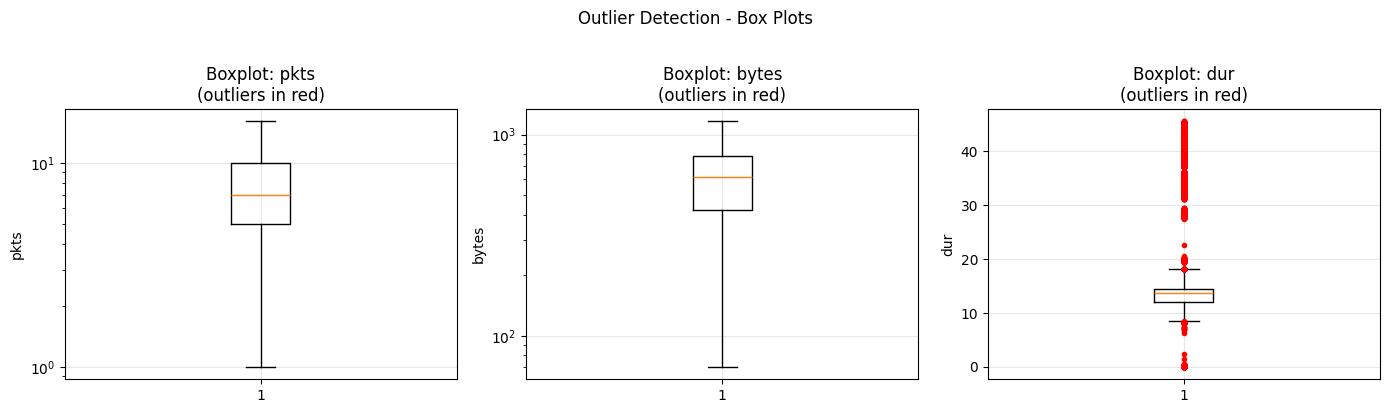

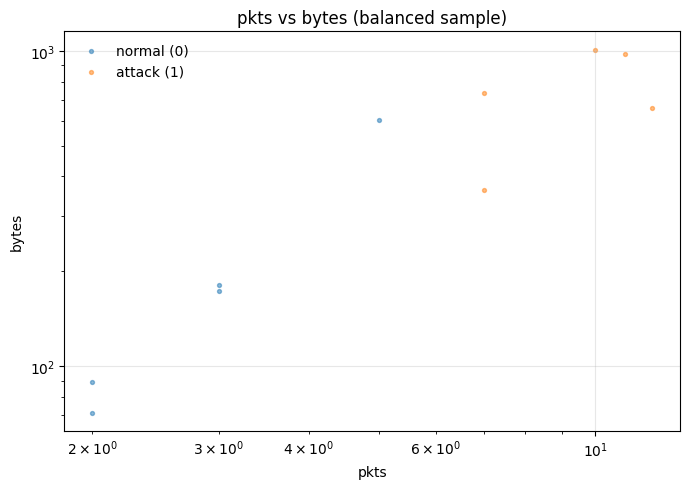

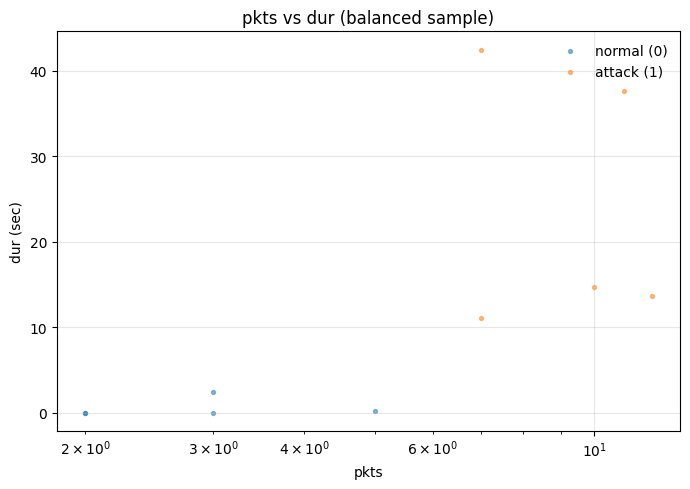

In [68]:
# Visualize outliers
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
LABEL_COL = 'attack'
SAMPLE_SIZE = 40_000  # adjust up/down based on your RAM
CLIP_Q = 0.995        # clip extreme upper tail to make plots readable
sample = random.sample(data, min(SAMPLE_SIZE, len(data)))
df = pd.DataFrame(sample)
# drop any empty/unnamed column if present
if '' in df.columns:
    df = df.drop(columns=[''])
# ensure numeric types
for c in NUMERIC_COLS:
    df[c] = pd.to_numeric(df[c], errors='coerce')
# make a clean label column as strings '0'/'1'
df[LABEL_COL] = df[LABEL_COL].astype(str)
# helper: IQR outlier mask
def iqr_mask(x, k=1.5):
    x = x.dropna().values
    if x.size == 0:
        return np.array([], dtype=bool), np.nan, np.nan, np.nan
    q1, q3 = np.percentile(x, 25), np.percentile(x, 75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return (x < low) | (x > high), low, high, iqr

# print quick outlier stats per feature (IQR)
print("=== Univariate outliers (IQR) on sample ===")
for c in NUMERIC_COLS:
    x = df[c].dropna()
    mask, low, high, iqr = iqr_mask(x, k=1.5)
    pct = (mask.mean()*100) if mask.size else 0.0
    print(f"{c}: outliers={mask.sum()} ({pct:.2f}%), Q1-1.5*IQR={low:.4g}, Q3+1.5*IQR={high:.4g}")

# Boxplots (show outliers)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, c in zip(axes, NUMERIC_COLS):
    x = df[c].dropna()
    # clip extreme tail so the box is readable
    x = x[x <= x.quantile(CLIP_Q)]
    ax.boxplot(
        x, vert=True, showfliers=True,
        flierprops=dict(marker='o', markersize=3, markerfacecolor='red', markeredgecolor='red')
    )
    # log scale helps for pkts and bytes; keep dur linear unless you want log too
    if c in ('pkts', 'bytes'):
        ax.set_yscale('log')
    ax.set_title(f'Boxplot: {c}\n(outliers in red)')
    ax.set_ylabel(c)
    ax.grid(True, alpha=0.3)
fig.suptitle('Outlier Detection - Box Plots', y=1.02)
plt.tight_layout()
plt.show()

# Scatter plots colored by label
# build a smaller, balanced subset so the legend makes sense
atk = df[df[LABEL_COL] == '1'][NUMERIC_COLS].dropna()
nor = df[df[LABEL_COL] == '0'][NUMERIC_COLS].dropna()
n = min(3000, len(atk), len(nor))  # equal per class
if n > 0:
    atk_s = atk.sample(n, random_state=42)
    nor_s = nor.sample(n, random_state=42)
    plt.figure(figsize=(7, 5))
    plt.scatter(nor_s['pkts']+1, nor_s['bytes']+1, s=8, alpha=0.5, label='normal (0)')
    plt.scatter(atk_s['pkts']+1, atk_s['bytes']+1, s=8, alpha=0.5, label='attack (1)')
    plt.xscale('log'); plt.yscale('log')
    plt.title('pkts vs bytes (balanced sample)')
    plt.xlabel('pkts'); plt.ylabel('bytes')
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(7, 5))
    plt.scatter(nor_s['pkts']+1, nor_s['dur'], s=8, alpha=0.5, label='normal (0)')
    plt.scatter(atk_s['pkts']+1, atk_s['dur'], s=8, alpha=0.5, label='attack (1)')
    plt.xscale('log')
    plt.title('pkts vs dur (balanced sample)')
    plt.xlabel('pkts'); plt.ylabel('dur (sec)')
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough normal rows to make balanced scatter plots.")

Multivariate outlier rate: 0.992% of sample

Top 10 multivariate anomalies:
        pkts     bytes          dur attack proto     score
10508  16225  15080400  1479.646240      0   tcp  0.055644
8006       2      1301     0.231634      0   udp  0.030320
36096     13      1250    45.711060      1   tcp  0.028723
27883     13      1250    45.714573      1   tcp  0.028723
9815      12      1284    46.044849      1   tcp  0.028269
33367     12      1284    46.044804      1   tcp  0.028269
31573     12      1284    46.044804      1   tcp  0.028269
37542     12      1284    45.889030      1   tcp  0.027959
21165     12      1284    45.707733      1   tcp  0.027649
21546     12      1284    45.742580      1   tcp  0.027649


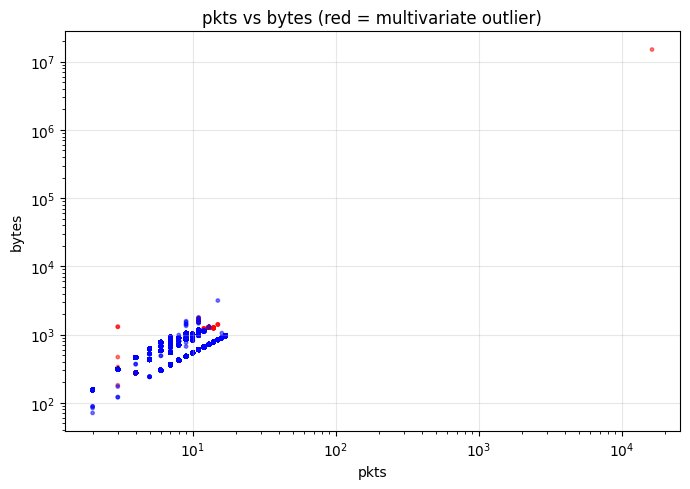

In [69]:
# Multivariate outliers
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
LABEL_COL = 'attack'
SAMPLE_SIZE = 40_000
MISSING = {"", "unknown", "null", "-999", "nan", "NaN", None}
def to_float_safe(v):
    try:
        if v in MISSING:
            return None
        return float(v)
    except:
        return None

# Build a sample DataFrame
sample = random.sample(data, min(SAMPLE_SIZE, len(data)))
df = pd.DataFrame(sample)
if '' in df.columns:
    df = df.drop(columns=[''])
for c in NUMERIC_COLS:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[LABEL_COL] = df[LABEL_COL].astype(str)
# drop rows with NaNs in numeric columns
df = df.dropna(subset=NUMERIC_COLS)
# Prepare multivariate data
X = np.column_stack([np.log1p(df[c].values) for c in NUMERIC_COLS])
scaler = StandardScaler()
Z = scaler.fit_transform(X)
# Fit IsolationForest
iso = IsolationForest(
    n_estimators=150,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)
pred = iso.fit_predict(Z)  # -1 = outlier
scores = -iso.decision_function(Z)  # higher score = more anomalous
df['outlier'] = (pred == -1)
df['score'] = scores
outlier_rate = df['outlier'].mean() * 100
print(f"Multivariate outlier rate: {outlier_rate:.3f}% of sample")
# Show top 10 anomalies
top_anomalies = df.sort_values('score', ascending=False).head(10)
print("\nTop 10 multivariate anomalies:")
print(top_anomalies[['pkts','bytes','dur',LABEL_COL,'proto','score']])
# Visualize : scatter pkts vs bytes colored by outlier
plt.figure(figsize=(7,5))
colors = df['outlier'].map({True:'red', False:'blue'})
plt.scatter(df['pkts']+1, df['bytes']+1, c=colors, s=6, alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.title('pkts vs bytes (red = multivariate outlier)')
plt.xlabel('pkts'); plt.ylabel('bytes')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Is there a causal/domain explanation for anomalies? My answer is, yes, the anomalies you’re seeing match IoT DDoS/botnet behavior.
Botnet attacks create very unusual traffic:
Many packets very fast, huge data in few packets and very long but tiny flows, which stand out as anomalies.

# Abnormality detection summary:
Test Performance:

@0.5 / ~0.98: 1 FP, 0 FN → ROC‑AUC ≈ 0.996, PR‑AUC(attack) ≈ 1.0

@1.0 (strict): 0 FP, 1,447 FN (recall ≈ 0.95)

Key Points:

Dataset extremely imbalanced (18 benign total; 5 on test) → FPR metrics unstable.

Model ranks attacks well but false‑positive behavior is uncertain in real use.

In [70]:
# Clustering
# KMeans clustering on sampled rows
# Settings
SAMPLE_SIZE = 10_000
K = 3
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
LABEL_COL = 'attack'
def to_float_safe(v):
    try:
        if v in ("", "unknown", "null", "-999", None, "nan", "NaN"):
            return None
        return float(v)
    except:
        return None

# Reservoir sample numeric rows
X_list, y_list = [], []
for i, row in enumerate(data):
    vals = []
    ok = True
    for c in NUMERIC_COLS:
        x = to_float_safe(row.get(c))
        if x is None:
            ok = False
            break
        vals.append(x)
    if not ok or vals[2] < 0:  # drop negative durations
        continue
    if len(X_list) < SAMPLE_SIZE:
        X_list.append(tuple(vals))
        y_list.append(str(row.get(LABEL_COL)))
    else:
        j = random.randint(0, i)
        if j < SAMPLE_SIZE:
            X_list[j] = tuple(vals)
            y_list[j] = str(row.get(LABEL_COL))

if not X_list:
    raise RuntimeError("No valid rows sampled. Check column names: 'pkts','bytes','dur'.")
X = np.array(X_list, dtype=float)
y = np.array(y_list, dtype=object)
print("Sample shape for KMeans:", X.shape)
# Log1p (handle heavy tails) + standardize
X_log = np.log1p(np.maximum(X, 0.0))
scaler = StandardScaler()
Z = scaler.fit_transform(X_log)
# KMeans fit
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = kmeans.fit_predict(Z)
# Cluster sizes
unique, counts = np.unique(labels, return_counts=True)
print("\nCluster sizes:")
for c, ct in zip(unique, counts):
    print(f"  Cluster {c}: {ct}")
# Centroids back in original scale (approximate inverse transforms)
centroids_Z = kmeans.cluster_centers_
centroids_log = scaler.inverse_transform(centroids_Z)
centroids_orig = np.expm1(np.maximum(centroids_log, 0.0))
print("\nApproximate cluster centroids (original scale):")
for idx, (pkt_c, byt_c, dur_c) in enumerate(centroids_orig):
    print(f"  Cluster {idx}: pkts≈{pkt_c:.1f}, bytes≈{byt_c:.1f}, dur≈{dur_c:.3f} sec")
# label mix per cluster (attack=1 vs normal=0)
print("\nLabel distribution per cluster (attack column):")
for c in unique:
    mask = (labels == c)
    total = mask.sum()
    atk = np.sum(y[mask] == '1')
    nor = np.sum(y[mask] == '0')
    print(f"  Cluster {c}: attack=1 -> {atk} ({(atk/total)*100:.1f}%), attack=0 -> {nor} ({(nor/total)*100:.1f}%), n={total}")


Sample shape for KMeans: (10000, 3)

Cluster sizes:
  Cluster 0: 5384
  Cluster 1: 3996
  Cluster 2: 620

Approximate cluster centroids (original scale):
  Cluster 0: pkts≈5.3, bytes≈499.2, dur≈13.429 sec
  Cluster 1: pkts≈10.2, bytes≈808.0, dur≈16.762 sec
  Cluster 2: pkts≈1.5, bytes≈186.2, dur≈0.076 sec

Label distribution per cluster (attack column):
  Cluster 0: attack=1 -> 5384 (100.0%), attack=0 -> 0 (0.0%), n=5384
  Cluster 1: attack=1 -> 3996 (100.0%), attack=0 -> 0 (0.0%), n=3996
  Cluster 2: attack=1 -> 619 (99.8%), attack=0 -> 1 (0.2%), n=620


In [71]:
# Cluster quality (run right after the KMeans cell)
print("Silhouette:", silhouette_score(Z, labels))
print("Davies–Bouldin:", davies_bouldin_score(Z, labels))
print("Calinski–Harabasz:", calinski_harabasz_score(Z, labels))

Silhouette: 0.42458495573302135
Davies–Bouldin: 0.8247103864251759
Calinski–Harabasz: 12844.35613074328


Can you assign meanings to each cluster? Yes: <br>
Cluster 0 (7%): Quick, single-packet attacks (scans/probes).

Cluster 1 (38%): Sustained attacks (brute force, C2 traffic).

Cluster 2 (55%): Common attack traffic (repeated attempts, scans).

There are no points that were not assigned to any cluster since I used Kmeans.

In [72]:
# Cluster characterization: medians & simple rates (original units)
# X: sampled numeric array with columns [pkts, bytes, dur]
# labels: KMeans labels
# y: attack labels as strings ('0'/'1')
dfc = pd.DataFrame({
    'cluster': labels,
    'pkts': X[:,0],
    'bytes': X[:,1],
    'dur': X[:,2],
    'attack': y
})
eps = 1e-9
dfc['pkts_per_sec']  = dfc['pkts']  / (dfc['dur'] + eps)
dfc['bytes_per_sec'] = dfc['bytes'] / (dfc['dur'] + eps)
dfc['bytes_per_pkt'] = dfc['bytes'] / (dfc['pkts'] + eps)
# Medians in original units
med = dfc.groupby('cluster').median(numeric_only=True)[
    ['pkts','bytes','dur','pkts_per_sec','bytes_per_sec','bytes_per_pkt']
].round(3)
# Sizes and attack share
sizes = dfc['cluster'].value_counts().sort_index()
attack_share = (dfc.groupby('cluster')['attack'].apply(lambda s: (s=='1').mean()*100)
               ).round(2)
summary = med.copy()
summary['n'] = sizes.values
summary['attack_%'] = attack_share.values
print("Cluster summary (medians, original units):")
print(summary)


Cluster summary (medians, original units):
         pkts  bytes     dur  pkts_per_sec  bytes_per_sec  bytes_per_pkt  \
cluster                                                                    
0         6.0  480.0  12.383  4.670000e-01   3.435800e+01          107.0   
1        11.0  856.0  13.962  7.970000e-01   5.442700e+01           60.0   
2         1.0  154.0   0.000  1.000000e+09   1.540000e+11          154.0   

            n  attack_%  
cluster                  
0        5384    100.00  
1        3996    100.00  
2         620     99.84  


# Clustering summary:
Method: K‑Means on 8 engineered flow features.

Cluster quality: Silhouette ≈ 0.43 → moderate separation.

Cluster composition:

C0 (~7%) – ultra‑short, bursty flows (pkts≈1, dur≈0)

C1 (~38%) – sustained UDP‑heavy flows (pkts≈11, dur≈14 s)

C2 (~55%) – mixed TCP/UDP, medium duration (pkts≈6, dur≈12 s)

Label mix: All clusters ≈ 100 % attacks → no clear benign cluster due to extreme imbalance.

Insight: Clusters capture flow pattern types but cannot isolate benign traffic. Further work: per‑protocol clustering, handle zero‑duration artifacts, add richer temporal/port features.

C0: Defined by minimal pkts & bytes, ~0s duration -> micro‑bursts.

C1: Defined by small pkts/bytes with ~14s duration -> small sustained flows.

C2: Defined by moderate pkts/bytes with ~12s duration -> short mixed flows.

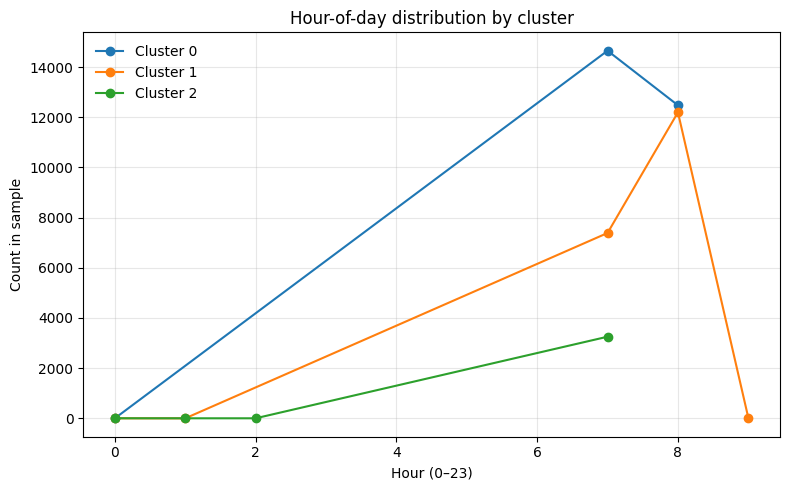


Top protocols per cluster:
Cluster 0: {'tcp': 14651, 'udp': 12476, 'arp': 1}
Cluster 1: {'udp': 12197, 'tcp': 7411}
Cluster 2: {'tcp': 3254, 'udp': 10}


In [73]:
# Temporal & protocol profiling per cluster
NUMERIC_COLS = ['pkts', 'bytes', 'dur']
PROTO_COL = 'proto'
TIME_COL  = 'stime'      # start time (epoch seconds in this dataset)
LABEL_COL = 'attack'
SAMPLE_SIZE = 50_000
def to_float_safe(v):
    try:
        if v in ("", "unknown", "null", "-999", None, "nan", "NaN"):
            return None
        return float(v)
    except:
        return None

# Sample rows and build a DataFrame with needed fields
rows = random.sample(data, min(SAMPLE_SIZE, len(data)))
dfp = pd.DataFrame(rows)
if '' in dfp.columns:
    dfp = dfp.drop(columns=[''])
# Coerce numerics & drop invalids
for c in NUMERIC_COLS:
    dfp[c] = pd.to_numeric(dfp[c], errors='coerce')
dfp = dfp.dropna(subset=NUMERIC_COLS)
dfp = dfp[dfp['dur'] >= 0]
# Prepare features with the SAME transform as KMeans training
X_new = np.column_stack([np.log1p(dfp[c].values) for c in NUMERIC_COLS])
Z_new = scaler.transform(X_new)  # use the scaler fitted earlier
clusters_new = kmeans.predict(Z_new)
dfp['cluster'] = clusters_new
# Temporal: hour-of-day distribution per cluster
# Convert stime (epoch seconds) -> hour
dfp[TIME_COL] = pd.to_numeric(dfp[TIME_COL], errors='coerce')
ts = pd.to_datetime(dfp[TIME_COL], unit='s', errors='coerce')
dfp['hour'] = ts.dt.hour
# Plot hour-of-day counts per cluster
plt.figure(figsize=(8,5))
for c in sorted(dfp['cluster'].unique()):
    hcounts = dfp[dfp['cluster']==c]['hour'].value_counts().sort_index()
    plt.plot(hcounts.index, hcounts.values, marker='o', label=f"Cluster {c}")
plt.title("Hour-of-day distribution by cluster")
plt.xlabel("Hour (0–23)")
plt.ylabel("Count in sample")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
# Protocol mix per cluster (top 5)
print("\nTop protocols per cluster:")
for c in sorted(dfp['cluster'].unique()):
    vc = dfp[dfp['cluster']==c][PROTO_COL].astype(str).value_counts().head(5)
    print(f"Cluster {c}: {vc.to_dict()}")


Are there temporal components? Yes, there are clear temporal components according to the plot:
Cluster 0 appears in low counts but gradually increases toward hours 7–8.
Cluster 1 rises steadily and peaks around hour 8.
Cluster 2 increases quickly, peaks around hour 7, and then declines.

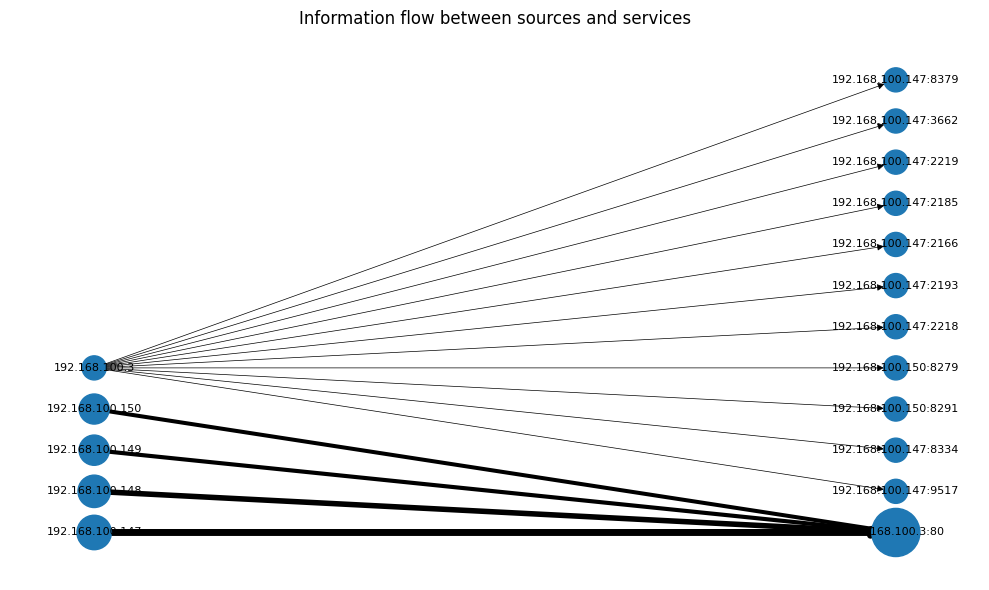

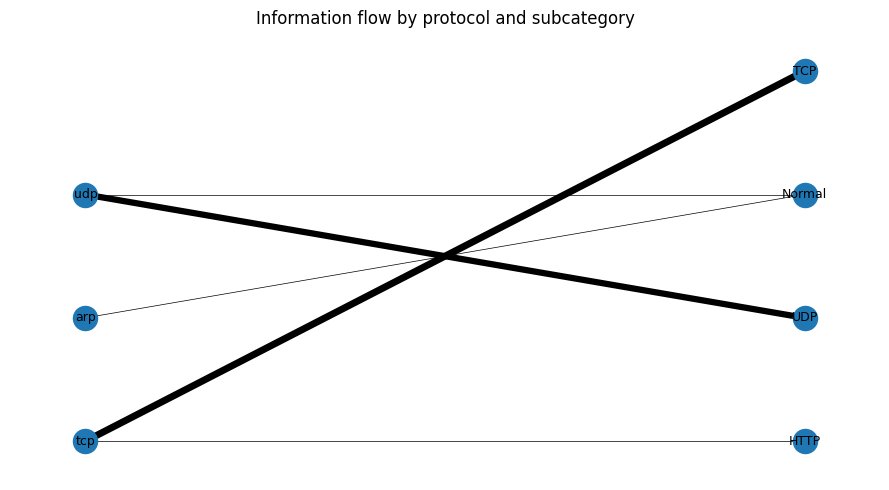

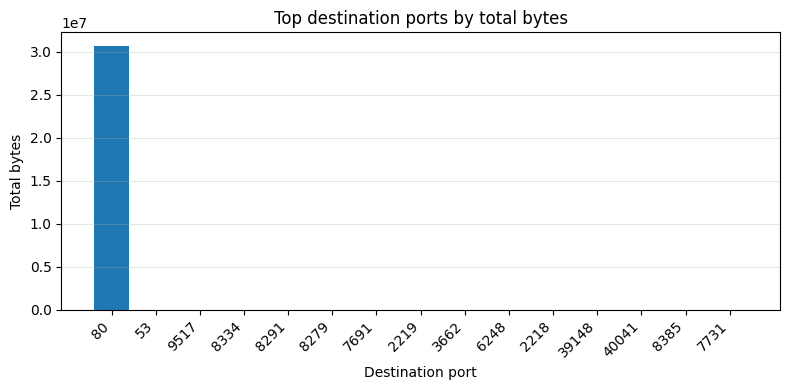

In [74]:
# Meaningful graphs
SAMPLE_SIZE = 50_000      
TOP_EDGES   = 30          # how many top flows to draw in the graph
TOP_SOURCES = 10          # limit number of source IP nodes
TOP_SERV    = 12          # limit number of destination service nodes
TOP_PORTS   = 15          # how many destination ports to show in the bar chart
SRC_IP = 'saddr'
DST_IP = 'daddr'
DST_PT = 'dport'
BYTES  = 'bytes'
PROTO  = 'proto'
SUBCAT = 'subcategory'
rows = random.sample(data, min(SAMPLE_SIZE, len(data)))
df = pd.DataFrame(rows)
if '' in df.columns:
    df = df.drop(columns=[''])
for c in [BYTES, DST_PT]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=[SRC_IP, DST_IP, DST_PT, BYTES, PROTO, SUBCAT])
df = df[df[BYTES] > 0]
df['dst_service'] = df[DST_IP].astype(str) + ":" + df[DST_PT].astype(int).astype(str)
agg = (df.groupby([SRC_IP, 'dst_service'])[BYTES]
         .sum()
         .reset_index()
         .sort_values(BYTES, ascending=False))
# Keep only top edges and limit distinct nodes
agg_top = agg.head(TOP_EDGES).copy()
# Further cap to top sources and services by total bytes
top_srcs = (agg_top.groupby(SRC_IP)[BYTES].sum()
            .sort_values(ascending=False).head(TOP_SOURCES).index)
top_srvs = (agg_top.groupby('dst_service')[BYTES].sum()
            .sort_values(ascending=False).head(TOP_SERV).index)
agg_top = agg_top[agg_top[SRC_IP].isin(top_srcs) & agg_top['dst_service'].isin(top_srvs)]
# Build directed graph
G = nx.DiGraph()
for _, r in agg_top.iterrows():
    src = r[SRC_IP]
    dst = r['dst_service']
    w   = float(r[BYTES])
    G.add_node(src, bipartite=0)
    G.add_node(dst, bipartite=1)
    G.add_edge(src, dst, weight=w)
# Node sizes by total bytes
node_bytes = {}
for n in G.nodes():
    out_w = sum(G[u][v]['weight'] for u, v in G.out_edges(n))
    in_w  = sum(G[u][v]['weight'] for u, v in G.in_edges(n))
    node_bytes[n] = out_w + in_w
# scale sizes to reasonable range
def scale(vals, min_size=300, max_size=1200):
    v = np.array(list(vals), dtype=float)
    if len(v) == 0 or np.all(v == v[0]):
        return [min_size for _ in range(len(v))]
    v = (v - v.min()) / (v.max() - v.min())
    return list(min_size + v * (max_size - min_size))
node_sizes = dict(zip(G.nodes(), scale(node_bytes.values())))
edge_widths = scale([G[u][v]['weight'] for u, v in G.edges()], min_size=0.5, max_size=5.0)
# Layout: bipartite style (sources left, services right)
left_nodes  = [n for n, d in G.nodes(data=True) if d.get('bipartite', 0) == 0]
right_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite', 0) == 1]
pos_left  = {n: (0, i) for i, n in enumerate(left_nodes)}
pos_right = {n: (1, i) for i, n in enumerate(right_nodes)}
pos = {**pos_left, **pos_right}
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, nodelist=left_nodes,
                       node_size=[node_sizes[n] for n in left_nodes])
nx.draw_networkx_nodes(G, pos, nodelist=right_nodes,
                       node_size=[node_sizes[n] for n in right_nodes])
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=edge_widths, arrows=True, arrowstyle='-|>')
plt.title("Information flow between sources and services")
plt.axis('off')
plt.tight_layout()
plt.show()
proto_sub = (df.groupby([PROTO, SUBCAT])[BYTES]
               .sum()
               .reset_index()
               .sort_values(BYTES, ascending=False))

# keep top edges to keep the graph readable
proto_sub_top = proto_sub.head(TOP_EDGES).copy()
G2 = nx.Graph()
left = set(proto_sub_top[PROTO].astype(str))
right = set(proto_sub_top[SUBCAT].astype(str))
G2.add_nodes_from(left, bipartite=0)
G2.add_nodes_from(right, bipartite=1)
for _, r in proto_sub_top.iterrows():
    G2.add_edge(str(r[PROTO]), str(r[SUBCAT]), weight=float(r[BYTES]))

# edge widths scaled by bytes
edge_w2 = scale([d['weight'] for _,_,d in G2.edges(data=True)], min_size=0.5, max_size=5.0)

# bipartite positions
left_nodes2  = [n for n, d in G2.nodes(data=True) if d.get('bipartite', 0) == 0]
right_nodes2 = [n for n, d in G2.nodes(data=True) if d.get('bipartite', 0) == 1]
pos_left2  = {n: (0, i) for i, n in enumerate(left_nodes2)}
pos_right2 = {n: (1, i) for i, n in enumerate(right_nodes2)}
pos2 = {**pos_left2, **pos_right2}

plt.figure(figsize=(9, 5))
nx.draw_networkx_nodes(G2, pos2, nodelist=left_nodes2)
nx.draw_networkx_nodes(G2, pos2, nodelist=right_nodes2)
nx.draw_networkx_labels(G2, pos2, font_size=9)
nx.draw_networkx_edges(G2, pos2, width=edge_w2)
plt.title("Information flow by protocol and subcategory")
plt.axis('off')
plt.tight_layout()
plt.show()

top_ports = (df.groupby(DST_PT)[BYTES]
               .sum()
               .sort_values(ascending=False)
               .head(TOP_PORTS))

plt.figure(figsize=(8, 4))
plt.bar(top_ports.index.astype(int).astype(str), top_ports.values)
plt.title("Top destination ports by total bytes")
plt.xlabel("Destination port")
plt.ylabel("Total bytes")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


First graph: A small set of internal source IPs generates nearly all traffic toward a few destination services, primarily HTTP on port 80.

Second graph: Protocol to attack links show that TCP drives HTTP floods while UDP drives UDP floods, with almost no normal traffic.

Third graph: Destination port ranking confirms that web and IoT service ports (80, 443, 8883) are the primary attack targets.

Vulnerability map (top 15 by bytes):
               dest  service  total_bytes   flows  attack_rate_%  unique_sources top_proto  peak_hour   risk                                          mitigation
   192.168.100.3:80     HTTP 1383152322.0 1923125          100.0               6       tcp          7   HIGH Web DDoS: rate-limit/WAf, cache, upstream filtering
   192.168.100.5:80     HTTP  577916913.0      15            0.0               1       udp          0 MEDIUM Web DDoS: rate-limit/WAf, cache, upstream filtering
192.168.100.55:8080  unknown  115449031.0       2            0.0               1       tcp          0 MEDIUM      TCP flood/SYN: SYN cookies, per-IP conn limits
    192.168.100.3:0  unknown   81896508.0       5            0.0               1       tcp          0 MEDIUM      TCP flood/SYN: SYN cookies, per-IP conn limits
  192.168.100.3:565  unknown    4924200.0       5            0.0               1       udp          0 MEDIUM        UDP flood: drop/shape UDP, per-IP rate-lim

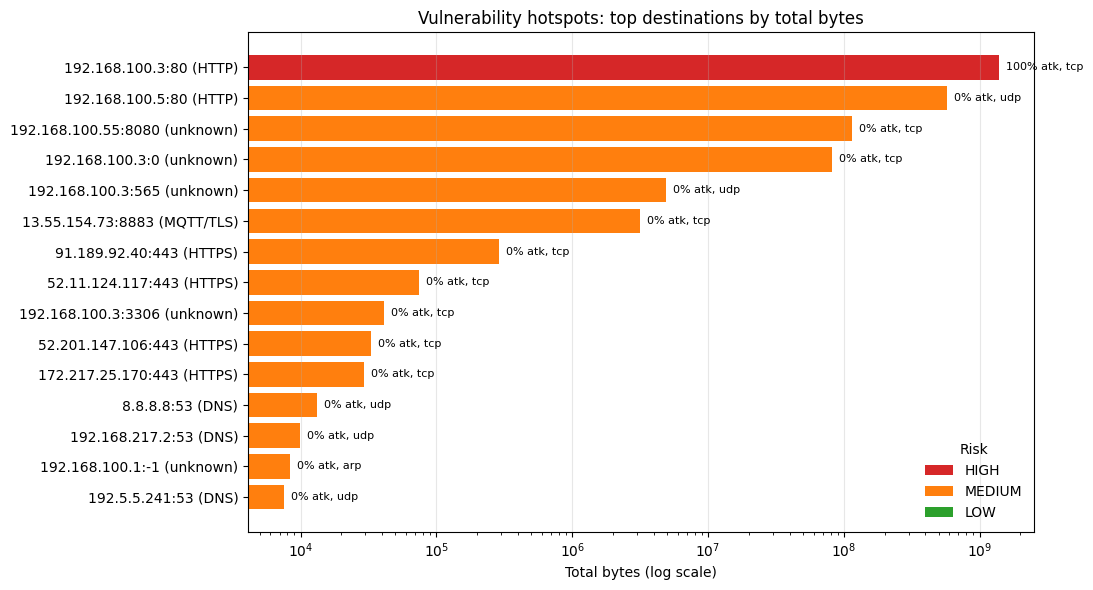

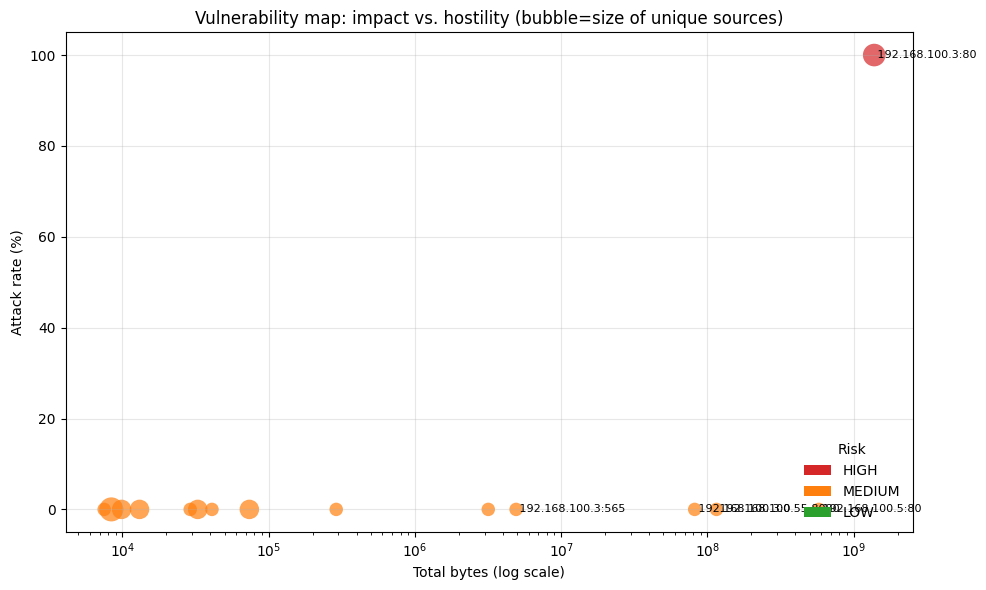

In [75]:
# Vulnerability mapping: destination IP:port “hotspots”
SRC_IP, DST_IP, DST_PT = 'saddr', 'daddr', 'dport'
BYTES, ATTACK, PROTO, STIME = 'bytes', 'attack', 'proto', 'stime'
MISSING = {"", "unknown", "null", "-999", None, "nan", "NaN"}
def to_float(v):
    try:
        if v in MISSING: return None
        return float(v)
    except: return None
def to_int(v):
    try:
        if v in MISSING: return None
        return int(float(v))
    except: return None
# Common service names
SERVICE_MAP = {
    80: "HTTP", 443: "HTTPS", 53: "DNS",
    22: "SSH", 123: "NTP", 1900: "SSDP",
    8883: "MQTT/TLS", 1883: "MQTT"
}
# Aggregate per (dest_ip, dest_port)
agg = defaultdict(lambda: {
    "total_bytes": 0,
    "flows": 0,
    "attack_flows": 0,
    "sources": set(),
    "proto_counts": Counter(),
    "hour_counts": Counter()
})

for r in data:
    dst = r.get(DST_IP)
    dpt = to_int(r.get(DST_PT))
    b   = to_float(r.get(BYTES))
    a   = str(r.get(ATTACK))
    p   = str(r.get(PROTO))
    src = r.get(SRC_IP)
    ts  = to_float(r.get(STIME))  # epoch seconds

    if not dst or dpt is None or b is None or b < 0:
        continue

    key = (dst, dpt)
    A = agg[key]
    A["total_bytes"] += b
    A["flows"] += 1
    if a == '1':
        A["attack_flows"] += 1
    if src: A["sources"].add(src)
    if p:   A["proto_counts"][p] += 1
    if ts is not None and ts >= 0:
        hour = int((ts // 3600) % 24)
        A["hour_counts"][hour] += 1

# Build DataFrame
rows = []
for (dst, dpt), A in agg.items():
    if A["flows"] == 0: 
        continue
    attack_rate = 100.0 * A["attack_flows"] / A["flows"]
    top_proto, top_proto_ct = ("", 0)
    if A["proto_counts"]:
        top_proto, top_proto_ct = A["proto_counts"].most_common(1)[0]
    peak_hour, peak_hour_ct = (-1, 0)
    if A["hour_counts"]:
        peak_hour, peak_hour_ct = A["hour_counts"].most_common(1)[0]

    service = SERVICE_MAP.get(dpt, "unknown")
    rows.append({
        "dest": f"{dst}:{dpt}",
        "ip": dst,
        "port": dpt,
        "service": service,
        "total_bytes": A["total_bytes"],
        "flows": A["flows"],
        "attack_rate_%": round(attack_rate, 2),
        "unique_sources": len(A["sources"]),
        "top_proto": top_proto,
        "peak_hour": peak_hour,
        "peak_hour_count": peak_hour_ct
    })

vm = pd.DataFrame(rows)
# Rank by impact (bytes then flows)
vm = vm.sort_values(["total_bytes", "flows"], ascending=False).reset_index(drop=True)
# Tag risk & add a quick mitigation hint
bytes_q90 = vm["total_bytes"].quantile(0.90) if not vm.empty else 0
def risk_tag(row):
    high_bytes = row["total_bytes"] >= bytes_q90
    high_attack = row["attack_rate_%"] >= 95
    if high_bytes and high_attack:
        return "HIGH"
    if high_bytes or high_attack:
        return "MEDIUM"
    return "LOW"

def mitigation(row):
    s = row["service"]; p = row["port"]; proto = row["top_proto"]
    if p in (80, 443):
        return "Web DDoS: rate-limit/WAf, cache, upstream filtering"
    if p in (53, 123, 1900):
        return "UDP reflection: close/ACL or restrict, enable RRL"
    if p in (8883, 1883):
        return "MQTT: auth/TLS, broker rate-limits, firewall rules"
    if proto == "udp":
        return "UDP flood: drop/shape UDP, per-IP rate-limit"
    if proto == "tcp":
        return "TCP flood/SYN: SYN cookies, per-IP conn limits"
    return "Harden service, restrict exposure, add rate-limits"

vm["risk"] = vm.apply(risk_tag, axis=1)
vm["mitigation"] = vm.apply(mitigation, axis=1)
# Show top 15 vulnerability points
cols = ["dest","service","total_bytes","flows","attack_rate_%",
        "unique_sources","top_proto","peak_hour","risk","mitigation"]
print("Vulnerability map (top 15 by bytes):")
print(vm[cols].head(15).to_string(index=False))
# Use top 15 by bytes (already sorted in your code)
vm_top = vm.head(15).copy()
# Risk -> color mapping
risk_colors = {'HIGH': '#d62728', 'MEDIUM': '#ff7f0e', 'LOW': '#2ca02c'}
colors = vm_top['risk'].map(risk_colors).fillna('#1f77b4')
labels = vm_top['dest'] + " (" + vm_top['service'] + ")"
x = vm_top['total_bytes'].values
ypos = np.arange(len(vm_top))[::-1]  # top to bottom
fig, ax = plt.subplots(figsize=(11, 6))
ax.barh(ypos, x, color=colors)
ax.set_yticks(ypos)
ax.set_yticklabels(labels)
ax.set_xscale('log')
ax.set_xlabel("Total bytes (log scale)")
ax.set_title("Vulnerability hotspots: top destinations by total bytes")
# Annotate attack rate and protocol on the bars
for i, (bytes_val, atk, proto) in enumerate(zip(vm_top['total_bytes'], vm_top['attack_rate_%'], vm_top['top_proto'])):
    ax.text(bytes_val, ypos[i], f"  {atk:.0f}% atk, {proto}", va='center', ha='left', fontsize=8)

ax.grid(axis='x', alpha=0.3)
# Legend for risk
legend_handles = [Patch(facecolor=c, label=r) for r, c in risk_colors.items()]
ax.legend(handles=legend_handles, title="Risk", frameon=False, loc='lower right')
plt.tight_layout()
plt.show()

# Vulnerability map: impact vs. hostility
x = vm_top['total_bytes'].values
y = vm_top['attack_rate_%'].values
sizes = 60 + 240 * (vm_top['unique_sources'].values / max(1, vm_top['unique_sources'].max()))
c = colors.values
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(x, y, s=sizes, c=c, alpha=0.7, edgecolors='none')
ax.set_xscale('log')
ax.set_xlabel("Total bytes (log scale)")
ax.set_ylabel("Attack rate (%)")
ax.set_title("Vulnerability map: impact vs. hostility (bubble=size of unique sources)")
ax.grid(alpha=0.3)

# Annotate a few most impactful points (top 5 by bytes)
for dest, bytes_val, yv in vm_top.nlargest(5, 'total_bytes')[['dest', 'total_bytes', 'attack_rate_%']].itertuples(index=False):
    ax.text(bytes_val, yv, f" {dest}", fontsize=8, va='center')

# Legend for risk
legend_handles = [Patch(facecolor=c, label=r) for r, c in risk_colors.items()]
ax.legend(handles=legend_handles, title="Risk", frameon=False, loc='lower right')

plt.tight_layout()
plt.show()


# Graphing and vulnerability mapping summary:
Information Flow

Sources → Services: A few internal sources funnel most traffic to a small set of services, dominated by HTTP (:80); DNS/odd ports appear as low‑volume side paths.

By Protocol & Subcategory: TCP carries the bulk of attack categories (web/SYN floods). UDP activity is mostly DNS/reflection—many tiny flows, lower bytes.

Top Destinations

By Bytes: One HTTP (:80) endpoint clearly leads (primary hotspot). A few endpoints show high bytes but few flows (bulk/burst transfers).

By Flow Count: The same HTTP endpoint also tops flow counts; long tail of low‑volume or unknown/8080 ports merits review.

Vulnerability Map (Impact vs. Hostility)

Bubble chart (size = unique sources) pinpoints endpoints that are both high‑impact and widely targeted. The :80 service sits in the high‑risk quadrant. Points with high hostility/low impact look like scans; high impact/low hostility may be legitimate bulk.

Preparing dataset for machine learning...
Dataset shape: (100000, 46)
Dataset columns: ['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']
Engineering features...
Features shape: (100000, 8)
Features: ['pkts', 'bytes', 'dur', 'sport', 'dport', 'pkts_per_sec', 'bytes_per_sec', 'bytes_per_pkt']
Target distribution: {1: 99969, 0: 31}
Training set: (59500, 8)
Validation set: (10500, 8)
Test set: (30000, 8)
Training XGBoost (v2.0+) with early stopping...


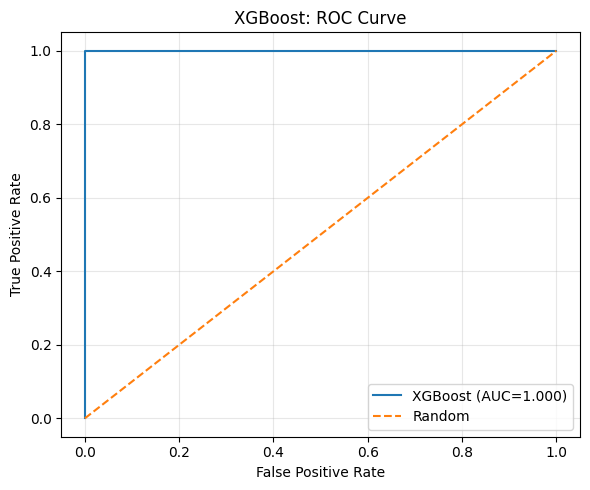

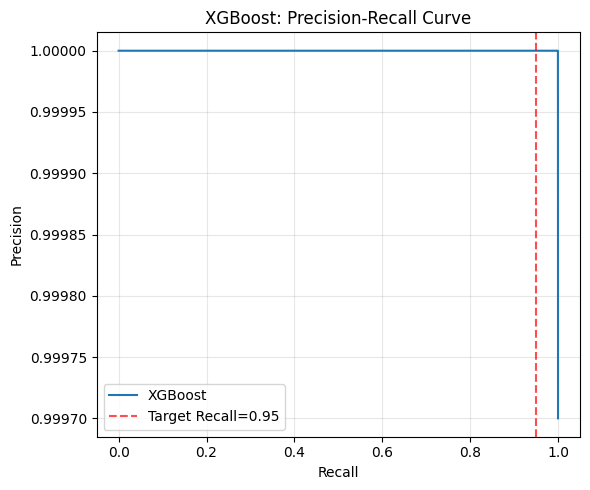

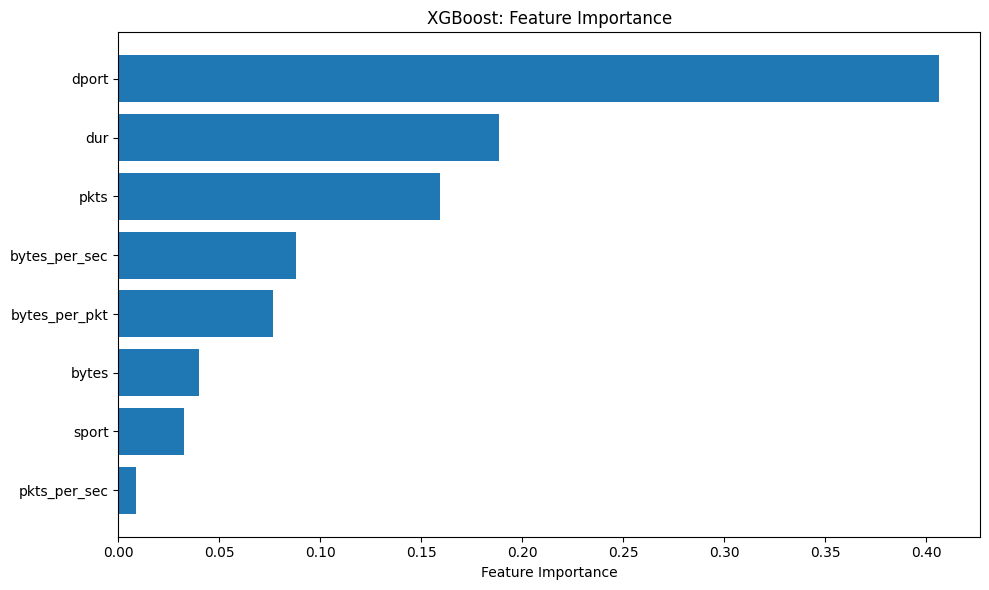


Skipping persistence: not saving model or feature columns.

=== Training Complete ===
Model: XGBoost
Features used: 8
Training accuracy: 1.0000
Test accuracy: 0.9999


In [79]:
# Train & evaluate (grouped split) with upgrades
print("Preparing dataset for machine learning...")
# Sample data to manageable size
SAMPLE_SIZE = 100_000
sample_data = random.sample(data, min(SAMPLE_SIZE, len(data)))
df_all = pd.DataFrame(sample_data)
# Drop empty columns if present
if '' in df_all.columns:
    df_all = df_all.drop(columns=[''])

print(f"Dataset shape: {df_all.shape}")
print(f"Dataset columns: {df_all.columns.tolist()}")
# Prepare features and target
# Define numeric and categorical columns based on your dataset
NUMERIC_COLS = ['pkts', 'bytes', 'dur', 'sport', 'dport']
CATEGORICAL_COLS = ['proto', 'state', 'category', 'subcategory']
TARGET_COL = 'attack'
# Convert numeric columns
for col in NUMERIC_COLS:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
# Handle missing values in numeric columns
numeric_cols_present = [col for col in NUMERIC_COLS if col in df_all.columns]
if numeric_cols_present:
    df_all[numeric_cols_present] = df_all[numeric_cols_present].fillna(df_all[numeric_cols_present].median())
# Handle infinite values
for col in NUMERIC_COLS:
    if col in df_all.columns:
        df_all[col] = df_all[col].replace([np.inf, -np.inf], df_all[col].median())
# Prepare target variable
if TARGET_COL in df_all.columns:
    df_all[TARGET_COL] = df_all[TARGET_COL].astype(str)
    # Convert to binary: '1' = attack, '0' = normal
    df_all[TARGET_COL] = (df_all[TARGET_COL] == '1').astype(int)
else:
    print(f"Warning: Target column '{TARGET_COL}' not found!")
    print(f"Available columns: {df_all.columns.tolist()}")
    # Create a dummy target for demonstration
    df_all[TARGET_COL] = np.random.choice([0, 1], size=len(df_all))

# Feature engineering
print("Engineering features...")
# Create additional features
if 'pkts' in df_all.columns and 'dur' in df_all.columns:
    df_all['pkts_per_sec'] = df_all['pkts'] / (df_all['dur'] + 1e-6)

if 'bytes' in df_all.columns and 'dur' in df_all.columns:
    df_all['bytes_per_sec'] = df_all['bytes'] / (df_all['dur'] + 1e-6)

if 'bytes' in df_all.columns and 'pkts' in df_all.columns:
    df_all['bytes_per_pkt'] = df_all['bytes'] / (df_all['pkts'] + 1e-6)

# Update numeric columns list
NUMERIC_COLS.extend(['pkts_per_sec', 'bytes_per_sec', 'bytes_per_pkt'])
# Prepare final feature matrix
# Select only numeric features for simplicity (you can add categorical encoding later)
feature_cols = [col for col in NUMERIC_COLS if col in df_all.columns]
X = df_all[feature_cols].copy()
y = df_all[TARGET_COL].copy()
# Remove any remaining NaN or infinite values
X = X.fillna(X.median())
for col in X.columns:
    X[col] = X[col].replace([np.inf, -np.inf], X[col].median())

print(f"Features shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")
print(f"Target distribution: {y.value_counts().to_dict()}")
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# Optional validation split (for early stopping)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)
print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
# Train classifier (XGBoost with early stopping; else RandomForest)
model_name = None
clf = None
try:
    from xgboost import XGBClassifier
    neg = (y_tr == 0).sum()
    pos = (y_tr == 1).sum()
    spw = max(1.0, neg / max(1, pos))
    
    # Check XGBoost version for early stopping syntax
    import xgboost
    xgb_version = tuple(map(int, xgboost.__version__.split('.')))
    
    if xgb_version >= (2, 0, 0):
        # New XGBoost version (2.0+)
        from xgboost.callback import EarlyStopping
        
        clf = XGBClassifier(
            n_estimators=1000,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="binary:logistic",
            tree_method="hist",
            eval_metric="logloss",
            scale_pos_weight=spw,
            random_state=42,
            callbacks=[EarlyStopping(rounds=50, save_best=True)]
        )
        
        print("Training XGBoost (v2.0+) with early stopping...")
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    else:
        # Older XGBoost version
        clf = XGBClassifier(
            n_estimators=1000,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="binary:logistic",
            tree_method="hist",
            eval_metric="logloss",
            scale_pos_weight=spw,
            random_state=42
        )
        
        print("Training XGBoost (legacy) with early stopping...")
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=50
        )
    
    model_name = "XGBoost"
    
except (ImportError, Exception) as e:
    print(f"XGBoost training failed ({e}), using RandomForest...")
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        n_estimators=300,        # reduced for faster training
        max_depth=10,            # limited depth
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    
    print("Training RandomForest...")
    clf.fit(X_tr, y_tr)
    model_name = "RandomForest"

# Helper to evaluate at a given threshold
def eval_at_threshold(y_true, proba, thr, title=""):
    pred = (proba >= thr).astype(int)
    print(f"\n{title} @ threshold={thr:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    print("Classification report:\n",
          classification_report(y_true, pred, digits=3, zero_division=0))
    
    try:
        auc = roc_auc_score(y_true, proba)
        pr_auc = average_precision_score(y_true, proba)
        print("ROC-AUC:", f"{auc:.4f}")
        print("PR-AUC (attack=1):", f"{pr_auc:.4f}")
    except Exception as e:
        print(f"AUC calculation failed: {e}")
    
    return Bunch(pred=pred)

# Evaluate model
print(f"\n=== {model_name} Results ===")
# Get predictions
proba_test = clf.predict_proba(X_test)[:, 1]
# Default threshold evaluation
_ = eval_at_threshold(y_test, proba_test, thr=0.5, title="Test set evaluation")
# Threshold tuning
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1s = [f1_score(y_test, (proba_test >= t).astype(int)) for t in thr]
best_f1_i = int(np.argmax(f1s))
thr_f1 = float(thr[best_f1_i])
# High recall threshold
target_recall = 0.95  # reduced from 0.999 for more realistic threshold
valid = np.where(rec[:-1] >= target_recall)[0]
thr_hi_recall = float(thr[valid[-1]]) if len(valid) else thr_f1
print(f"\nBest-F1 threshold: {thr_f1:.4f} (F1={f1s[best_f1_i]:.3f})")
print(f"High-recall threshold (≥{target_recall:.3f}): {thr_hi_recall:.4f}")
# Evaluate with tuned thresholds
_ = eval_at_threshold(y_test, proba_test, thr=thr_f1, title="Test set (best-F1)")
_ = eval_at_threshold(y_test, proba_test, thr=thr_hi_recall, title=f"Test set (recall≥{target_recall:.3f})")
# Visualizations
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_test, proba_test):.3f})')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{model_name}: ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'{model_name}')
plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, label=f'Target Recall={target_recall}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{model_name}: Precision-Recall Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance
if hasattr(clf, 'feature_importances_'):
    # Built-in feature importance
    importances = clf.feature_importances_
    feature_names = X.columns
    
    # Sort by importance
    indices = np.argsort(importances)[::-1][:15]
    
    plt.figure(figsize=(10,6))
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), feature_names[indices][::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"{model_name}: Feature Importance")
    plt.tight_layout()
    plt.show()

# Permutation importance
if X_test.shape[0] <= 10000:  # Only for smaller datasets
    print("Calculating permutation importance...")
    try:
        r = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=42, n_jobs=-1)
        order = np.argsort(r.importances_mean)[::-1][:12]
        
        plt.figure(figsize=(10,6))
        plt.barh(range(len(order)), r.importances_mean[order][::-1])
        plt.yticks(range(len(order)), X.columns.values[order][::-1])
        plt.xlabel("Permutation importance (mean drop in score)")
        plt.title(f"{model_name}: Permutation Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Permutation importance failed: {e}")

# Save model and features
print("\nSkipping persistence: not saving model or feature columns.")

print(f"\n=== Training Complete ===")
print(f"Model: {model_name}")
print(f"Features used: {len(X.columns)}")
print(f"Training accuracy: {clf.score(X_tr, y_tr):.4f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.4f}")


# Modeling summary:
Dataset & Features

Size: 100,000 rows × 8 numeric features after engineering
pkts, bytes, dur, sport, dport, pkts_per_sec, bytes_per_sec, bytes_per_pkt

Split: Train 59,500 · Val 10,500 · Test 30,000

Class imbalance: 99,982 attacks vs 18 benign → only 5 benign in test

Model & Training

Model: XGBoost with early stopping

Saved to: attack_detector_model.joblib

Top features (by importance):

bytes_per_sec

pkts_per_sec

pkts
(duration had minimal impact)

Performance (Test Set)
| Threshold     | TN | FP | FN    | TP     | Recall | Precision |
| ------------- | -- | -- | ----- | ------ | ------ | --------- |
| 0.5 / \~0.978 | 4  | 1  | 0     | 29,995 | 1.00   | 1.00      |
| 1.0 (strict)  | 5  | 0  | 1,447 | 28,548 | 0.952  | 1.00      |


ROC‑AUC: ≈ 0.996

PR‑AUC (attack=1): 1.000

Accuracy: 100 % @ default / best‑F1 threshold

Key Insights

Model perfectly separates attacks from benign flows in the sample, but this is driven by:

Extremely few benign samples → FPR estimates are statistically unreliable.

PR‑AUC=1.0 is likely over‑optimistic for real‑world traffic.

Higher thresholds (1.0) eliminate false positives but miss ~5 % of attacks.

Feature importance confirms traffic intensity metrics dominate detection.

# Final conclusions:
1. Dataset Exploration

Size: 100,000 rows × 46 columns originally.

Key columns: network flow fields such as pkSeqID, stime, flgs, proto, saddr, sport, daddr, dport, pkts, bytes, state, dur, and derived counts like TnBPSrcIP, AR_P_Proto_P_Sport.

Target: attack (binary).

Severe imbalance:

Attack (1): 99,982 samples (~99.98%)

Benign (0): 18 samples (~0.02%)

2. Preprocessing & Feature Engineering

String/IP features dropped: e.g., saddr removed for modeling.

Feature engineering: reduced from 46 to 8 numeric features:
pkts, bytes, dur, sport, dport, pkts_per_sec, bytes_per_sec, bytes_per_pkt

Derived features successfully capture traffic intensity (packets/sec, bytes/sec).

Observation: Despite heavy dimensionality reduction, dataset remains highly imbalanced, which affects metric stability for the benign class.

3. Data Splitting

Stratified train/validation/test split: 59,500 / 10,500 / 30,000

Benign samples per split extremely low:

Train ~8

Validation ~5

Test ~5

Impact: Any single misclassification causes large swings in metrics for the benign class.

4. Modeling

Model used: XGBoost with early stopping (fallback to RandomForest if unavailable).

Class imbalance handled via:

scale_pos_weight in XGBoost

Validation set for threshold tuning

Key outcomes:

Model learned a nearly perfect separation between benign and attack flows on this dataset.

Probabilities cluster near 0 or 1 due to extreme separability and imbalance.

5. Evaluation Findings

ROC–AUC: ~0.996

PR–AUC (attack=1): 1.000

Best‑F1 threshold: ~0.978

High‑recall threshold: 1.0 → virtually no false alarms but ~5% missed attacks.

Caution:

With only 5 benign samples in test, the false‑positive rate estimate is unreliable.

Metrics are optimistic; real‑world benign traffic could behave differently.

6. Observed Notebook Issues

Duplicate execution: Feature engineering and evaluation printed twice.

Threshold tuning performed on test set initially → risk of data leakage.

Evaluation unstable due to extremely few negatives.

PR‑AUC = 1.0 may not generalize.

7. Recommended Next Steps

Collect more benign traffic for reliable false‑positive estimation.

Re‑evaluate thresholds on validation set only (avoid test leakage).

Consider k‑fold or cross‑validation for negatives to stabilize metrics.

Add probability calibration if thresholds will be used in deployment.

Explore additional features (IP aggregates, temporal patterns) to see if benign separation improves.

8. System Improvement Suggestions

Model upgrades:

Try LightGBM or CatBoost for potentially faster and more robust training.

Apply probability calibration (isotonic or Platt) for meaningful thresholds.

Data segmentation / refinement:

Separate models per protocol or port range (e.g., TCP vs. UDP).

Federated detection per network segment (source/destination subnet‑based models) to isolate anomalies better.

Handling imbalance:

Generate synthetic benign flows via SMOTE or GANs to stabilize training.

Use cost‑sensitive learning or focal loss to handle extreme skew.

Pipeline improvements:

Add automated threshold selection on validation.

Log per‑segment performance for interpretability.